In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torch.optim as optim
from torchvision.io import read_image
from torch import tensor
import time
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

F:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seed = 13
np.random.seed(seed)

In [3]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

In [4]:
class SiameseResNet(nn.Module):
    def __init__(self):
        super(SiameseResNet, self).__init__()
        if torch.cuda.is_available(): 
            dev = "cuda:0" 
        else: 
            dev = "cpu" 
        self.dev = torch.device(dev) 
        # Load pre-trained ResNet-18 models
        self.cnn1 = self.load_pretrained_model()
        self.cnn2 = self.load_pretrained_model()
        
        for param in list(self.cnn1.parameters()):
            param.requires_grad = False
        for param in list(self.cnn2.parameters()):
            param.requires_grad = False
        
        # Add a new layer on top
        self.classifier = nn.Sequential(
            nn.LayerNorm(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LayerNorm(4096),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LayerNorm(4096),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LayerNorm(4096),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )
        self.to(self.dev)
        
    def load_pretrained_model(self):
        # Download and load a pre-trained ResNet-18 model
        model = models.resnet50(weights=True)
        return nn.Sequential(*list(model.children())[:-1])
        
    def forward_once(self, x1, x2):
        # Forward pass through both of the CNN branches
        out1 = self.cnn1(x1)
        out1 = out1.view(out1.size()[0], -1)
        out2 = self.cnn2(x2)
        out2 = out2.view(out2.size()[0], -1)
        return out1, out2
    
    def forward(self, input1, input2):
        # Forward pass through both CNN branches
        output1, output2 = self.forward_once(input1.to(self.dev), input2.to(self.dev))
        
        # Concatenate the outputs of both branches
        combined = torch.cat((output1, output2), dim=1)
        #print("COMBINED")
        #print(combined)
        # Forward pass through the new layer
        output = self.classifier(combined)
        #print("OUTPUT : " + str(output))
        #print("SIGMOID")
        #print(torch.sigmoid(output))
        return output # Apply sigmoid activation for binary classification


In [19]:
def train_model(model, num_epochs, train_max_index, path_train, weight_n, lr):
    weight = tensor([weight_n]).to(device) #
    criterion = nn.BCELoss(weight = weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_start = time.time()
        loading_time_start = time.time()
        cum_loss = 0.

        for i in range(train_max_index + 1):
            with open(path_train + str(i) + ".pkl", 'rb') as inp:
                data = pickle.load(inp)
            if i % 10 == 9:
                print("loading time : " + str(time.time() - loading_time_start))
            mini_epoch_start = time.time()
            img1, img2, labels = data
            reshaped_labels = torch.reshape(labels, (labels.shape[0], 1)).to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            value_before = float(list(model.parameters())[-1][0])
            # Forward pass
            outputs = model(img1, img2)
            # Calculate loss
            loss = criterion(outputs, reshaped_labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            value_after = float(list(model.parameters())[-1][0])
            if abs(value_before - value_after) < 0.000000000001:
                print("VALUES ARE THE SAME")

            # Print statistics
            running_loss += loss.item()
            cum_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print('%f per batch : [%d, %5d] loss: %.3f' %
                      (time.time() - mini_epoch_start, epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
            loading_time_start = time.time()
        model.eval()
        loss_train, loss_test, acc_train, acc_test = evaluate_model_prep(model, criterion, True)
        print('\n loss train: %.3f; acc train %.3f \n loss test %.3f acc test %.3f' %
                      (loss_train, acc_train * 100, loss_test, acc_test * 100))
        model.train()
        epoch_end = time.time()
        print("EPOCH TIME : " + str(epoch_end - epoch_start))
        print("Cumulative loss: %.3f" % (cum_loss))
    print('Finished Training')
    return model

In [6]:
def get_predictions_and_metrics(model, threshold = 0.5):
    correct_labels = []
    predict_labels = []
    model.eval()
    path = "processed_eval/"
    max_index = 37
    with torch.no_grad():
        for i in range (max_index + 1):
            with open(path + str(i) + ".pkl", 'rb') as inp:
                data = pickle.load(inp)
            img1, img2, labels = data
            correct_labels = correct_labels + labels.tolist()
            reshaped_labels = torch.reshape(labels, (labels.shape[0], 1)).to(device)

            # Forward pass
            outputs = model(img1, img2)
            # Calculate loss
            predictions = (outputs > threshold).float()
            predict_labels = predict_labels + predictions.tolist()
    print(confusion_matrix(correct_labels, predict_labels))
    print('precision %.3f, recall %.3f, f1 %.3f' %
              (precision_score(correct_labels, predict_labels), recall_score(correct_labels, predict_labels), f1_score(correct_labels, predict_labels)))
    return predict_labels, correct_labels

In [14]:
def evaluate_model_prep(model, criterion = nn.BCELoss(weight = tensor([13]).to(device)), disable_train = False):
    path_train = "processed_dataset/"
    train_max_index = 180
    path_test = "processed_eval/"
    test_max_index = 37
    loss1 = 0.
    acc1 = 0.
    if not disable_train:
        loss1, acc1 = model_eval_prep(model, path_train, train_max_index, criterion)
    loss2, acc2 = model_eval_prep(model, path_test, test_max_index, criterion)
    return loss1, loss2, acc1, acc2

def model_eval_prep(model, path, max_index, criterion):
    total_correct = 0.
    total_samples = 0.
    total_loss = 0.
    with torch.no_grad():
        for i in range (max_index + 1):
            with open(path + str(i) + ".pkl", 'rb') as inp:
                data = pickle.load(inp)
            img1, img2, labels = data
            reshaped_labels = torch.reshape(labels, (labels.shape[0], 1)).to(device)
            # Forward pass
            outputs = model(img1, img2)
            # Calculate loss
            loss = criterion(outputs, reshaped_labels)
            
            predictions = (outputs > 0.5).float()
            correct = (predictions == reshaped_labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
            total_loss += loss
    return total_loss/total_samples, float(total_correct)/total_samples

In [20]:
model = SiameseResNet()

F:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model = train_model(model, 1, 679, "processed_dataset_augmented/", 5, 0.00001)
model = train_model(model, 4, 679, "processed_dataset_augmented/", 5, 0.0000001)

loading time : 0.04021191596984863
0.138181 per batch : [1,    10] loss: 3.206
loading time : 0.04252147674560547
0.140176 per batch : [1,    20] loss: 2.418
loading time : 0.044536590576171875
0.138845 per batch : [1,    30] loss: 3.221
loading time : 0.04462766647338867
0.141565 per batch : [1,    40] loss: 2.511
loading time : 0.04575324058532715
0.141197 per batch : [1,    50] loss: 1.943
loading time : 0.046260833740234375
0.153799 per batch : [1,    60] loss: 2.131
loading time : 0.042809486389160156
0.140908 per batch : [1,    70] loss: 2.019
loading time : 0.04220747947692871
0.140198 per batch : [1,    80] loss: 1.796
loading time : 0.0418238639831543
0.151893 per batch : [1,    90] loss: 1.649
loading time : 0.043370723724365234
0.146467 per batch : [1,   100] loss: 1.748
loading time : 0.042658090591430664
0.147862 per batch : [1,   110] loss: 1.690
loading time : 0.05019330978393555
0.141318 per batch : [1,   120] loss: 1.926
loading time : 0.04499936103820801
0.150648 per 

loading time : 0.04651451110839844
0.140921 per batch : [1,   350] loss: 1.348
loading time : 0.05078721046447754
0.139965 per batch : [1,   360] loss: 1.543
loading time : 0.04354429244995117
0.139615 per batch : [1,   370] loss: 0.999
loading time : 0.04363703727722168
0.140210 per batch : [1,   380] loss: 1.810
loading time : 0.04778480529785156
0.140381 per batch : [1,   390] loss: 1.730
loading time : 0.05236244201660156
0.144935 per batch : [1,   400] loss: 1.173
loading time : 0.047336578369140625
0.140013 per batch : [1,   410] loss: 1.571
loading time : 0.04838109016418457
0.140316 per batch : [1,   420] loss: 1.561
loading time : 0.048352956771850586
0.140482 per batch : [1,   430] loss: 1.435
loading time : 0.04864335060119629
0.140199 per batch : [1,   440] loss: 1.327
loading time : 0.045992136001586914
0.139772 per batch : [1,   450] loss: 1.222
loading time : 0.049649715423583984
0.141183 per batch : [1,   460] loss: 1.297
loading time : 0.044119834899902344
0.141107 per

loading time : 0.048127174377441406
0.140598 per batch : [2,   680] loss: 1.556

 loss train: 0.000; acc train 0.000 
 loss test 0.038 acc test 91.008
EPOCH TIME : 135.9973647594452
Cumulative loss: 919.943
loading time : 0.046605587005615234
0.168592 per batch : [3,    10] loss: 1.027
loading time : 0.04850292205810547
0.166046 per batch : [3,    20] loss: 1.226
loading time : 0.04758024215698242
0.167074 per batch : [3,    30] loss: 1.960
loading time : 0.0481877326965332
0.164154 per batch : [3,    40] loss: 1.401
loading time : 0.049506187438964844
0.139926 per batch : [3,    50] loss: 1.046
loading time : 0.04751086235046387
0.144499 per batch : [3,    60] loss: 1.363
loading time : 0.04688549041748047
0.140265 per batch : [3,    70] loss: 1.099
loading time : 0.04860520362854004
0.141050 per batch : [3,    80] loss: 1.278
loading time : 0.04216337203979492
VALUES ARE THE SAME
0.140569 per batch : [3,    90] loss: 0.971
loading time : 0.05207037925720215
0.140737 per batch : [3,  

loading time : 0.0442204475402832
0.140516 per batch : [4,   310] loss: 1.434
loading time : 0.04692411422729492
0.140028 per batch : [4,   320] loss: 1.493
VALUES ARE THE SAME
loading time : 0.04597759246826172
0.140360 per batch : [4,   330] loss: 1.447
loading time : 0.04957270622253418
0.141085 per batch : [4,   340] loss: 1.166
loading time : 0.04609394073486328
0.139927 per batch : [4,   350] loss: 1.166
loading time : 0.05152583122253418
0.140733 per batch : [4,   360] loss: 1.393
loading time : 0.04740571975708008
0.139646 per batch : [4,   370] loss: 1.136
loading time : 0.05129814147949219
0.139737 per batch : [4,   380] loss: 1.740
loading time : 0.04895281791687012
0.140728 per batch : [4,   390] loss: 1.596
loading time : 0.04797792434692383
0.140391 per batch : [4,   400] loss: 1.226
loading time : 0.04576897621154785
0.140974 per batch : [4,   410] loss: 1.464
loading time : 0.047238826751708984
0.140591 per batch : [4,   420] loss: 1.845
loading time : 0.045371532440185

In [22]:
pred, corr = get_predictions_and_metrics(model, 0.5)

[[960  60]
 [ 48 122]]
precision 0.670, recall 0.718, f1 0.693


Here I put it to create an expanded dataset with augmentations

After augmenting with     
transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    
Best metrics were
[[993 111]
 [  6  79]]
precision 0.416, recall 0.929, f1 0.575

It's strange that so far I can't even make it overfit

Turns out my data is prob shit 124

[[453  57]
 [ 37 133]]
precision 0.700, recall 0.782, f1 0.739

[[493  17]
 [ 52 118]]
precision 0.874, recall 0.694, f1 0.774
precision 0.822, recall 0.818, f1 0.820
[[950  70]
 [ 37 133]]
precision 0.655, recall 0.782, f1 0.713
0.796 x2
0.810 x3


In [15]:
pred

[[1.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],


In [16]:
corr

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [17]:
p = np.array(pred)[::2]
pc = p.reshape(p.shape[0], )
c = np.array(corr)[::2]

In [18]:
len(corr[::2])

595

In [19]:
pred[0]+pred[1]

[1.0, 1.0]

In [20]:
pc

array([1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [21]:
c

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [22]:
pc != c

array([False,  True,  True,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False, False,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False, False,  True,  True, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [23]:
df_test = pd.read_csv("df_test.csv", index_col = 0)

In [24]:
df_test[pc != c].index.values

array([  1,   2,   3,   4,   7,  17,  18,  19,  20,  22,  23,  33,  37,
        38,  43,  44,  47,  53,  54,  59,  60,  64,  69,  70,  74,  80,
        85,  86,  90,  96, 108, 112, 114, 124, 137, 153, 162, 178, 237,
       253, 261, 277, 320, 329, 332, 336, 345, 348, 360, 376, 397, 486,
       528, 589], dtype=int64)

In [25]:
df_test[pc != c]

path1  \
1    dataset/RGB/uav_images/DJI_0466.JPG   
2    dataset/RGB/uav_images/DJI_0294.JPG   
3    dataset/RGB/uav_images/DJI_0502.JPG   
4    dataset/RGB/uav_images/DJI_0618.JPG   
7    dataset/RGB/uav_images/DJI_0539.JPG   
17   dataset/RGB/uav_images/DJI_0274.JPG   
18   dataset/RGB/uav_images/DJI_0391.JPG   
19   dataset/RGB/uav_images/DJI_0593.JPG   
20   dataset/RGB/uav_images/DJI_0377.JPG   
22   dataset/RGB/uav_images/DJI_0490.JPG   
23   dataset/RGB/uav_images/DJI_0642.JPG   
33   dataset/RGB/uav_images/DJI_0671.JPG   
37   dataset/RGB/uav_images/DJI_0285.JPG   
38   dataset/RGB/uav_images/DJI_0679.JPG   
43   dataset/RGB/uav_images/DJI_0318.JPG   
44   dataset/RGB/uav_images/DJI_0452.JPG   
47   dataset/RGB/uav_images/DJI_0400.JPG   
53   dataset/RGB/uav_images/DJI_0334.JPG   
54   dataset/RGB/uav_images/DJI_0269.JPG   
59   dataset/RGB/uav_images/DJI_0325.JPG   
60   dataset/RGB/uav_images/DJI_0641.JPG   
64   dataset/RGB/uav_images/DJI_0669.JPG   
69   dataset/RGB/uav_images/DJI_0519.JPG   
70   dataset/RGB/uav_images/DJI_0474.JPG   
74   dataset/RGB/uav_images/DJI_0357.JPG   
80   dataset/RGB/uav_images/DJI_0532.JPG   
85   dataset/RGB/uav_images/DJI_0297.JPG   
86   dataset/RGB/uav_images/DJI_0466.JPG   
90   dataset/RGB/uav_images/DJI_0267.JPG   
96   dataset/RGB/uav_images/DJI_0481.JPG   
108  dataset/RGB/uav_images/DJI_0642.JPG   
112  dataset/RGB/uav_images/DJI_0328.JPG   
114  dataset/RGB/uav_images/DJI_0646.JPG   
124  dataset/RGB/uav_images/DJI_0561.JPG   
137  dataset/RGB/uav_images/DJI_0505.JPG   
153  dataset/RGB/uav_images/DJI_0434.JPG   
162  dataset/RGB/uav_images/DJI_0615.JPG   
178  dataset/RGB/uav_images/DJI_0673.JPG   
237  dataset/RGB/uav_images/DJI_0534.JPG   
253  dataset/RGB/uav_images/DJI_0373.JPG   
261  dataset/RGB/uav_images/DJI_0333.JPG   
277  dataset/RGB/uav_images/DJI_0490.JPG   
320  dataset/RGB/uav_images/DJI_0304.JPG   
329  dataset/RGB/uav_images/DJI_0357.JPG   
332  dataset/RGB/uav_images/DJI_0615.JPG   
336  dataset/RGB/uav_images/DJI_0381.JPG   
345  dataset/RGB/sat_images/DJI_0267.JPG   
348  dataset/RGB/sat_images/DJI_0673.JPG   
360  dataset/RGB/sat_images/DJI_0377.JPG   
376  dataset/RGB/sat_images/DJI_0402.JPG   
397  dataset/RGB/sat_images/DJI_0385.JPG   
486  dataset/RGB/sat_images/DJI_0296.JPG   
528  dataset/RGB/sat_images/DJI_0391.JPG   
589  dataset/RGB/sat_images/DJI_0597.JPG   

                                                 path2  label  
1                  dataset/RGB/sat_images/DJI_0466.JPG      1  
2                  dataset/RGB/sat_images/DJI_0294.JPG      1  
3                  dataset/RGB/sat_images/DJI_0502.JPG      1  
4                  dataset/RGB/sat_images/DJI_0618.JPG      1  
7                  dataset/RGB/sat_images/DJI_0539.JPG      1  
17                 dataset/RGB/sat_images/DJI_0274.JPG      1  
18                 dataset/RGB/sat_images/DJI_0391.JPG      1  
19                 dataset/RGB/sat_images/DJI_0593.JPG      1  
20                 dataset/RGB/sat_images/DJI_0377.JPG      1  
22                 dataset/RGB/sat_images/DJI_0490.JPG      1  
23                 dataset/RGB/sat_images/DJI_0642.JPG      1  
33                 dataset/RGB/sat_images/DJI_0671.JPG      1  
37                 dataset/RGB/sat_images/DJI_0285.JPG      1  
38                 dataset/RGB/sat_images/DJI_0679.JPG      1  
43                 dataset/RGB/sat_images/DJI_0318.JPG      1  
44                 dataset/RGB/sat_images/DJI_0452.JPG      1  
47                 dataset/RGB/sat_images/DJI_0400.JPG      1  
53                 dataset/RGB/sat_images/DJI_0334.JPG      1  
54                 dataset/RGB/sat_images/DJI_0269.JPG      1  
59                 dataset/RGB/sat_images/DJI_0325.JPG      1  
60                 dataset/RGB/sat_images/DJI_0641.JPG      1  
64                 dataset/RGB/sat_images/DJI_0669.JPG      1  
69                 dataset/RGB/sat_images/DJI_0519.JPG      1  
70                 dataset/RGB/sat_images/DJI_0474.JPG      1  
74            

In [26]:
df_test[df_test.index == 112]

path1  \
112  dataset/RGB/uav_images/DJI_0328.JPG   

                                                 path2  label  
112  dataset/RGB/false_sat_images/(38.6198774370064...      0

In [27]:
list(model.cnn1.parameters())[-1]

Parameter containing:
tensor([0.0084, 0.0549, 0.0348,  ..., 0.0219, 0.0207, 0.0076], device='cuda:0')

In [28]:
with open("processed_eval/" + str(35) + ".pkl", 'rb') as inp:
        data = pickle.load(inp)

In [29]:
model(data[0][0], data[1][0])

ValueError: expected 4D input (got 3D input)

In [30]:
model

SiameseResNet(
  (cnn1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [31]:
img1, img2, labels = data

In [32]:
model(img1, img2)

tensor([[0.0009],
        [0.0016],
        [0.0095],
        [0.0367],
        [0.0012],
        [0.0040],
        [0.0007],
        [0.0009],
        [0.1671],
        [0.0007],
        [0.0042],
        [0.0021],
        [0.0176],
        [0.0612],
        [0.0017],
        [0.0005],
        [0.0891],
        [0.1432],
        [0.0004],
        [0.0005],
        [0.0030],
        [0.0009],
        [0.0090],
        [0.0014],
        [0.0023],
        [0.0036],
        [0.0009],
        [0.0023],
        [0.0021],
        [0.0216],
        [0.0148],
        [0.0266]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
models.vgg16().parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [34]:
tmp = list(models.vgg16().parameters())

In [35]:
nn.Sequential(*list(models.resnet18().children())[:-1])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [36]:
loss_train, loss_test, acc_train, acc_test = evaluate_model_prep(model, nn.BCELoss(weight = tensor([2]).to(device)), False)

KeyboardInterrupt: 

In [47]:
loss_train

tensor(0.0219, device='cuda:0')

In [48]:
loss_test

tensor(0.0079, device='cuda:0')

In [49]:
acc_train

0.908477508650519

In [50]:
acc_test

0.9487394957983193

In [37]:
def prep_img(img_path):
    img = read_image(img_path)
    # Transformations to apply to the images
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy arrays to PIL images
        transforms.Resize((224, 224)),# Resize images to fit ResNet input size
        transforms.ToTensor(),# Convert images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image pixels
    ])
    img_res = transform(img)
    return img, img_res.unsqueeze(0)

In [38]:
uav = "dataset/RGB/uav_images/"
sat = "dataset/RGB/sat_images/"
fsat = "dataset/RGB/false_sat_images/"

In [39]:
img, prep = prep_img(sat + "DJI_0466.JPG")

F:\anaconda\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [40]:
img

tensor([[[115, 115,  97,  ...,  98, 113, 114],
         [116, 116,  97,  ...,  87, 101, 102],
         [119, 117,  97,  ...,  82,  96,  96],
         ...,
         [253, 253, 253,  ..., 241, 222, 222],
         [253, 253, 253,  ..., 253, 237, 237],
         [253, 253, 253,  ..., 254, 238, 239]],

        [[115, 115,  97,  ...,  93, 108, 109],
         [116, 116,  97,  ...,  82,  96,  97],
         [119, 117,  97,  ...,  77,  91,  91],
         ...,
         [253, 253, 253,  ..., 239, 219, 220],
         [253, 253, 253,  ..., 251, 235, 235],
         [253, 253, 253,  ..., 252, 236, 237]],

        [[115, 115,  99,  ...,  97, 112, 113],
         [116, 116,  99,  ...,  86, 100, 101],
         [119, 117,  99,  ...,  81,  95,  95],
         ...,
         [253, 253, 253,  ..., 244, 226, 225],
         [253, 253, 253,  ..., 254, 240, 238],
         [253, 253, 253,  ..., 255, 239, 240]]], dtype=torch.uint8)

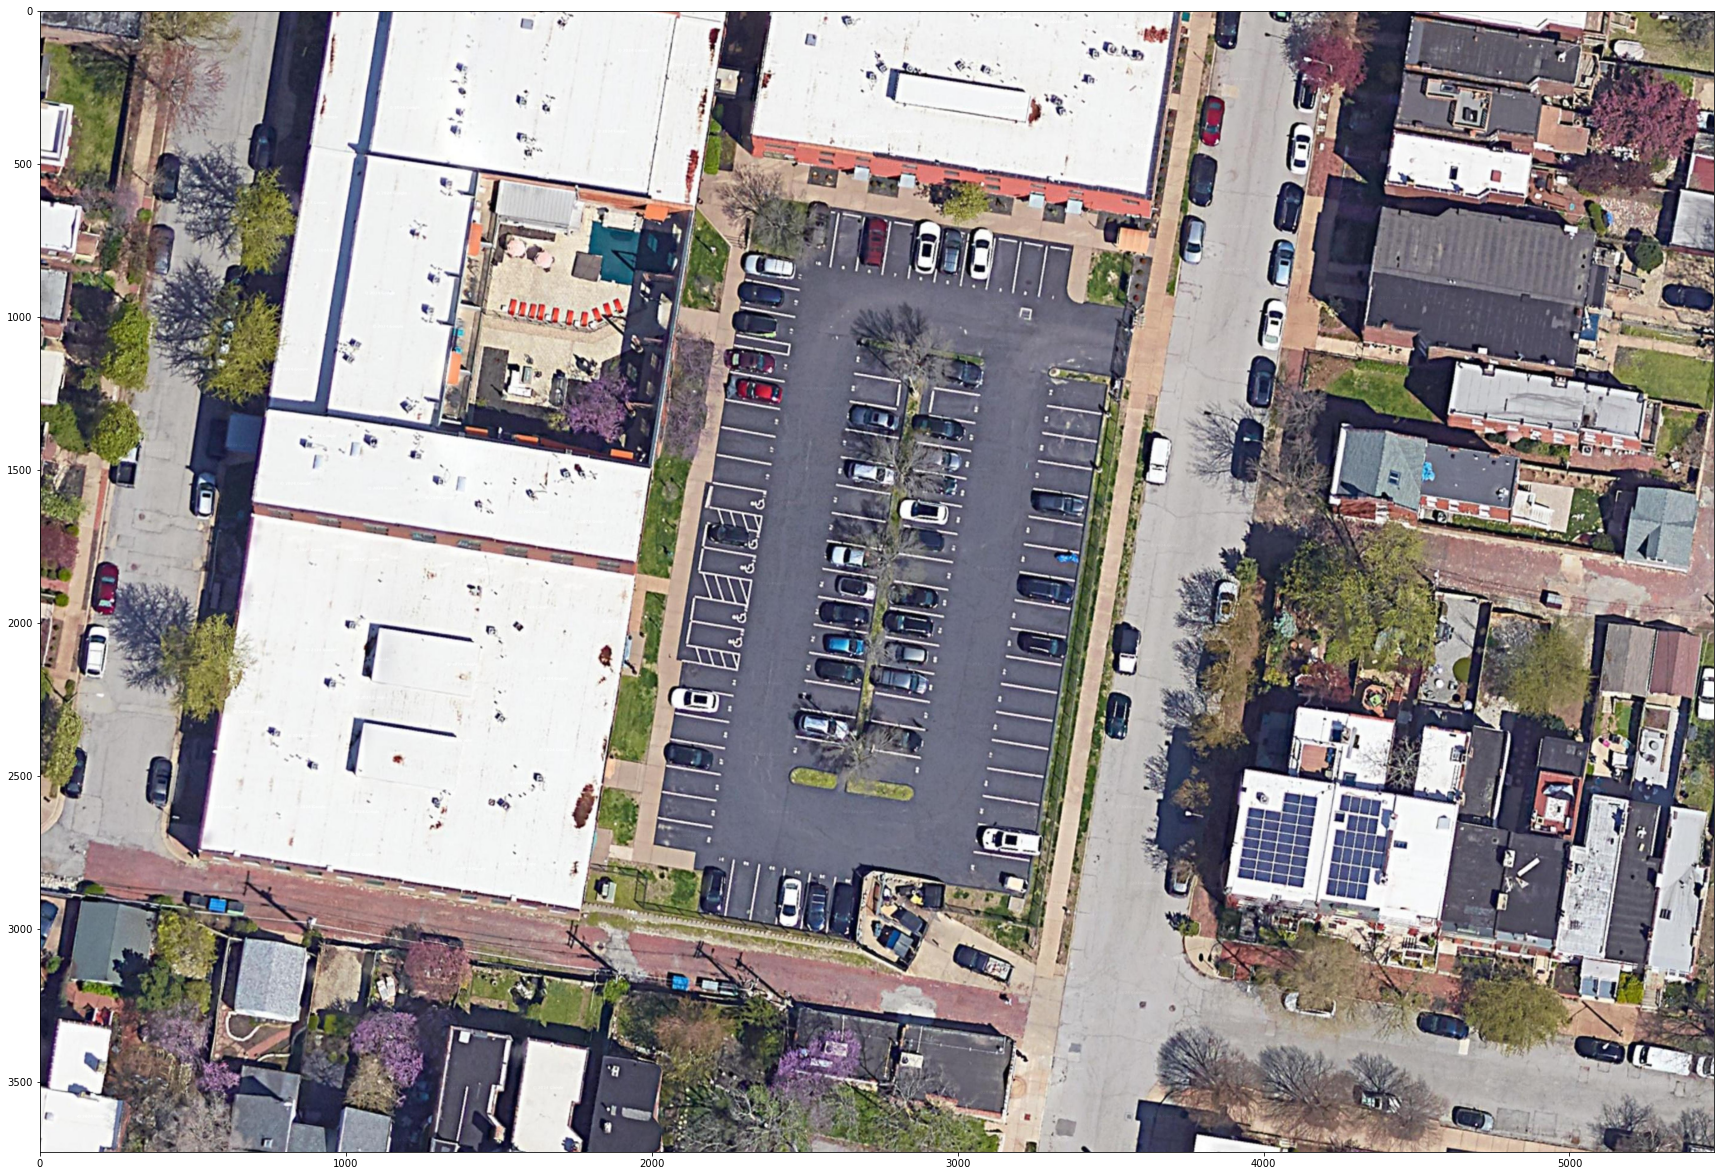

In [41]:
plt.figure(figsize = (30,30))
plt.imshow(img.permute(1, 2, 0))

In [42]:
s466 = prep_img(sat + "DJI_0466.JPG")
u466 = prep_img(uav + "DJI_0466.JPG")
s465 = prep_img(sat + "DJI_0465.JPG")
u465 = prep_img(uav + "DJI_0465.JPG")

In [43]:
model.eval()
with torch.no_grad():
    logits = model(u465[1], s465[1])

In [44]:
logits

tensor([[0.9987]], device='cuda:0')

??????

In [45]:
    model.eval()
for k in range(267, 692):
        fname = "DJI_0" + str(k) + ".JPG"
        s = prep_img(sat + fname)
        u = prep_img(uav + fname)

        with torch.no_grad():
            logits = model(u[1], s[1])
        if(logits[0][0] < 0.5):
            print(k)
        print(logits)

tensor([[0.9729]], device='cuda:0')
tensor([[0.9795]], device='cuda:0')
tensor([[0.9918]], device='cuda:0')
tensor([[0.9370]], device='cuda:0')
tensor([[0.9724]], device='cuda:0')
tensor([[0.9669]], device='cuda:0')
tensor([[0.9427]], device='cuda:0')
tensor([[0.9787]], device='cuda:0')
tensor([[0.9938]], device='cuda:0')
tensor([[0.9902]], device='cuda:0')
tensor([[0.9146]], device='cuda:0')
tensor([[0.9357]], device='cuda:0')
tensor([[0.9638]], device='cuda:0')
tensor([[0.7504]], device='cuda:0')
tensor([[0.9701]], device='cuda:0')
tensor([[0.9325]], device='cuda:0')
tensor([[0.8289]], device='cuda:0')
tensor([[0.9558]], device='cuda:0')
tensor([[0.8361]], device='cuda:0')
tensor([[0.7617]], device='cuda:0')
287
tensor([[0.4027]], device='cuda:0')
288
tensor([[0.3910]], device='cuda:0')
289
tensor([[0.3183]], device='cuda:0')
290
tensor([[0.4181]], device='cuda:0')
tensor([[0.6947]], device='cuda:0')
tensor([[0.8528]], device='cuda:0')
tensor([[0.7958]], device='cuda:0')
tensor([[0.9

tensor([[0.9964]], device='cuda:0')
tensor([[0.9946]], device='cuda:0')
tensor([[0.9925]], device='cuda:0')
tensor([[0.9935]], device='cuda:0')
tensor([[0.9776]], device='cuda:0')
tensor([[0.9924]], device='cuda:0')
tensor([[0.9942]], device='cuda:0')
tensor([[0.9831]], device='cuda:0')
tensor([[0.9817]], device='cuda:0')
tensor([[0.9935]], device='cuda:0')
tensor([[0.9946]], device='cuda:0')
tensor([[0.9945]], device='cuda:0')
tensor([[0.9970]], device='cuda:0')
tensor([[0.9765]], device='cuda:0')
tensor([[0.9906]], device='cuda:0')
tensor([[0.9947]], device='cuda:0')
tensor([[0.9621]], device='cuda:0')
tensor([[0.9359]], device='cuda:0')
tensor([[0.9945]], device='cuda:0')
tensor([[0.9795]], device='cuda:0')
tensor([[0.9922]], device='cuda:0')
tensor([[0.9814]], device='cuda:0')
tensor([[0.9906]], device='cuda:0')
tensor([[0.9650]], device='cuda:0')
tensor([[0.9935]], device='cuda:0')
tensor([[0.9805]], device='cuda:0')
tensor([[0.9883]], device='cuda:0')
tensor([[0.9958]], device='c

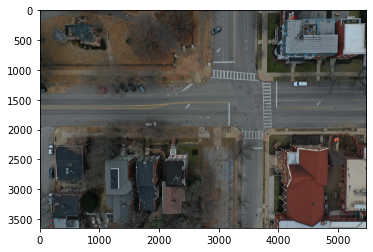

In [56]:
cropper = transforms.RandomCrop(size=(128, 128))
crops = [cropper(u[0]) for _ in range(4)]
plt.imshow(u[0].permute(1,2,0))

In [59]:
crops = [cropper(u[0]) for _ in range(4)]


In [63]:
crops[0].size()

torch.Size([3, 128, 128])

In [48]:
vals = df_test[df_test.label == 1].path1.values

In [49]:
vals

array(['dataset/RGB/uav_images/DJI_0297.JPG',
       'dataset/RGB/uav_images/DJI_0466.JPG',
       'dataset/RGB/uav_images/DJI_0294.JPG',
       'dataset/RGB/uav_images/DJI_0502.JPG',
       'dataset/RGB/uav_images/DJI_0618.JPG',
       'dataset/RGB/uav_images/DJI_0267.JPG',
       'dataset/RGB/uav_images/DJI_0333.JPG',
       'dataset/RGB/uav_images/DJI_0539.JPG',
       'dataset/RGB/uav_images/DJI_0673.JPG',
       'dataset/RGB/uav_images/DJI_0590.JPG',
       'dataset/RGB/uav_images/DJI_0345.JPG',
       'dataset/RGB/uav_images/DJI_0481.JPG',
       'dataset/RGB/uav_images/DJI_0374.JPG',
       'dataset/RGB/uav_images/DJI_0562.JPG',
       'dataset/RGB/uav_images/DJI_0336.JPG',
       'dataset/RGB/uav_images/DJI_0486.JPG',
       'dataset/RGB/uav_images/DJI_0343.JPG',
       'dataset/RGB/uav_images/DJI_0274.JPG',
       'dataset/RGB/uav_images/DJI_0391.JPG',
       'dataset/RGB/uav_images/DJI_0593.JPG',
       'dataset/RGB/uav_images/DJI_0377.JPG',
       'dataset/RGB/uav_images/DJI